In [1]:
from optimal_MM import MarketMakerMDP
import numpy as np
from rl.distribution import Constant
from rl.policy import DeterministicPolicy
from rl.markov_process import NonTerminal

Generate 10000 optimal traces

In [2]:
mm_mdp = MarketMakerMDP()
optimal_policy = mm_mdp.get_optimal_policy()
start_states = Constant(NonTerminal((0,100,0,0)))
traces_iter = mm_mdp.action_traces(start_states, optimal_policy)

traces = []
for _ in range(10000):
    traces.append(next(traces_iter))


Calculate avg spread

In [3]:
ba_spreads = []
for i,trace in enumerate(traces):
    if i % 1000 == 0:
        print(i//1000)
    for step in trace:
        ba_spreads.append(step.action[1] - step.action[0])

avg_spread = np.average(ba_spreads)
print(avg_spread)

0
1
2
3
4
5
6
7
8
9
1.490770422751421


Generate 10000 traces with fixed spread = to the average optimal spread

In [4]:
def fixed_spread_pol_func(state):
    return state[1] - avg_spread/2, state[1] + avg_spread/2
fixed_spread_pol = DeterministicPolicy(fixed_spread_pol_func)

fixed_spread_traces_iter = mm_mdp.action_traces(start_states,fixed_spread_pol)

fixed_spread_traces = []
while len(fixed_spread_traces) < 10000:
    fixed_spread_traces.append(next(fixed_spread_traces_iter))

For both naive and optimal policies, get the marked-to-market pnls from t=0 to T from 1000 simulation traces

In [13]:
fixed_m2m_pnls = []
opt_m2m_pnls = []
for _ in range(1000):
    fixed_trace = next(fixed_spread_traces_iter)
    fixed_t, fixed_St, fixed_Wt, fixed_It = list(zip(*[step.state.state for step in fixed_trace]))
    fixed_m2m_pnls.append([Wt +It*St for Wt, It, St in zip(fixed_Wt,fixed_It,fixed_St)])
    
    opt_trace = next(traces_iter)
    opt_t, opt_St, opt_Wt, opt_It = list(zip(*[step.state.state for step in opt_trace]))
    opt_m2m_pnls.append([Wt +It*St for Wt, It, St in zip(opt_Wt,opt_It,opt_St)])

In [9]:
import matplotlib.pyplot as plt

Plot the average marked to market pnls for both policies as a function of time. Notice that the naive policy actually seems to outperform the optimal policy on average.

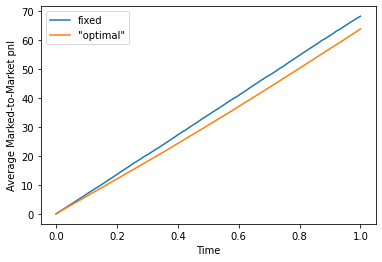

In [23]:
avg_fixed_m2m_pnl = np.mean(fixed_m2m_pnls,axis=0)
avg_opt_m2m_pnl = np.mean(opt_m2m_pnls,axis=0)

plt.plot([i*0.005 for i in range(len(avg_fixed_m2m_pnl))], avg_fixed_m2m_pnl, label='fixed')
plt.plot([i*0.005 for i in range(len(avg_opt_m2m_pnl))], avg_opt_m2m_pnl,label='"optimal"')
plt.xlabel('Time')
plt.ylabel('Average Marked-to-Market pnl')
plt.legend()
plt.savefig('m2m_pnl_averages.png')

It's fine for the naive policy to outperform the optimal policy on average m2m pnl, as long as the average utility of pnl at time T is higher for the optimal policy. Let's confirm that this is the case:

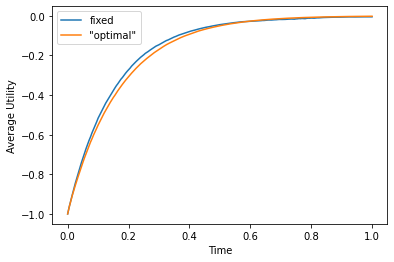

In [34]:
gamma=0.1
fixed_utilities = -np.exp(-gamma*np.array(fixed_m2m_pnls))
opt_utilities = -np.exp(-gamma*np.array(opt_m2m_pnls))
avg_fixed_utility = np.mean(fixed_utilities,axis=0)
avg_opt_utility = np.mean(opt_utilities,axis=0)

plt.plot([i*0.005 for i in range(len(avg_fixed_utility))], avg_fixed_utility, label='fixed')
plt.plot([i*0.005 for i in range(len(avg_opt_utility))], avg_opt_utility,label='"optimal"')
plt.xlabel('Time')
plt.ylabel('Average Utility')
plt.legend()
plt.savefig('utility_vs_time_1.png')

Another way of visualizing this is by plotting $-\log(-\mathbb{E}[U(pnl)])$. -log(-x) is an increasing function of x,  and helps illustrate the difference between the fixed and optimal policies over time better. From this graph, we can see that the optimal policy significantly outperforms the naive policy over the last 40% of the experiment

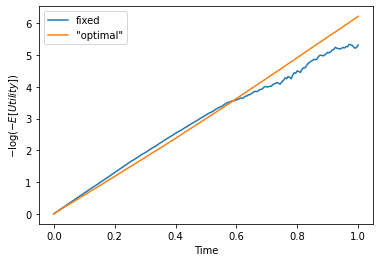

In [35]:
plt.plot([i*0.005 for i in range(len(avg_fixed_utility))], -np.log(-avg_fixed_utility), label='fixed')
plt.plot([i*0.005 for i in range(len(avg_opt_utility))], -np.log(-avg_opt_utility),label='"optimal"')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$-\\log(-E[Utility])$')
plt.savefig('Utility_vs_time_2.png')

Why is this the case? It comes down to the fact that while the average pnl of the fixed policy might be higher, its standard deviation of pnl is also way higher towards t=T:

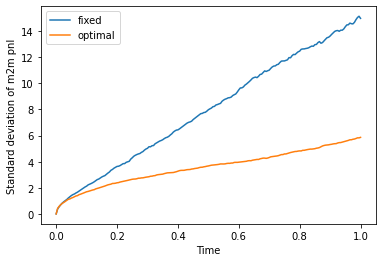

In [39]:
fixed_m2m_pnl_stdev = np.std(fixed_m2m_pnls,axis=0)
opt_m2m_pnl_stdev = np.std(opt_m2m_pnls,axis=0)

plt.plot([i*0.005 for i in range(len(fixed_m2m_pnl_stdev))], fixed_m2m_pnl_stdev, label='fixed')
plt.plot([i*0.005 for i in range(len(opt_m2m_pnl_stdev))], opt_m2m_pnl_stdev, label = 'optimal')
plt.xlabel('Time')
plt.ylabel('Standard deviation of m2m pnl')
plt.legend()
plt.savefig('pnl_stdev_vs_time.png')